<a href="https://colab.research.google.com/github/RecoHut-Projects/recohut/blob/master/tutorials/modeling/T948935_deep_vae_recsys_filmtrust_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Variational Models on FilmTrust Dataset in Tensorflow

<img src='https://github.com/RecoHut-Stanzas/S394070/raw/main/images/flow.svg'>

## **Step 1 - Setup the environment**

### **1.1 Install libraries**

In [ ]:
!pip install -q -U git+https://github.com/RecoHut-Projects/recohut.git -b v0.0.2

### **1.2 Download datasets**

In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Datasets/filmtrust/raw/v1/ft.csv
# !wget -q --show-progress https://github.com/RecoHut-Datasets/movielens_1m/raw/v3/ml1m.csv
# !wget -q --show-progress https://github.com/RecoHut-Datasets/myanimelist/raw/v1/anime.zip

ft.csv              100%[===================>] 452.87K  --.-KB/s    in 0.03s   


### **1.3 Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, ndcg_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# models
from recohut.models.tf.deepmf import DeepMF
from recohut.models.tf.ncf import NCF
from recohut.models.tf.vdeepmf import VDeepMF
from recohut.models.tf.vncf import VNCF

# metrics
from recohut.metrics.utils import calculate_precision_recall
from recohut.metrics.utils import calculate_ndcg

### **1.4 Set params**

In [ ]:
class Args:
    def __init__(self, dataset):
        self.dataset = dataset
        if dataset == 'ml1m':
            self.latent_dim = 5
            self.like_threshold = 4
            self.steps_per_epoch = None
            self.deepmf_epochs = 10
            self.ncf_epochs = 10
            self.vdeepmf_epochs = 6
            self.vncf_epochs = 9
        elif dataset == 'ft':
            self.latent_dim = 5
            self.like_threshold = 3
            self.steps_per_epoch = None
            self.deepmf_epochs = 15
            self.ncf_epochs = 8
            self.vdeepmf_epochs = 10
            self.vncf_epochs = 6
        elif dataset == 'anime':
            self.latent_dim = 7
            self.like_threshold = 8
            self.steps_per_epoch = None
            self.deepmf_epochs = 20
            self.ncf_epochs = 15
            self.vdeepmf_epochs = 9
            self.vncf_epochs = 9

In [ ]:
args = Args(dataset='ft')

## **Step 2 - Data preparation**

In [ ]:
df = pd.read_csv(args.dataset+'.csv', delimiter = ',')

num_users = df.user.max() + 1
num_items = df.item.max() + 1

X = df[['user', 'item']].to_numpy()
y = df[['rating']].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = [X_train[:,0], X_train[:,1]]
X_test = [X_test[:,0], X_test[:,1]]

## **Step 3 - Model training**

### **3.1 DeepMF**

In [ ]:
model = DeepMF(num_users=num_users, num_items=num_items, latent_dim=args.latent_dim)
deepmf = model.build()

deepmf.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
deepmf.summary()

deepmf_report = deepmf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=args.deepmf_epochs, steps_per_epoch=args.steps_per_epoch, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 5)         10355       ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         7540        ['input_1[0][0]']                
                                                                                              

### **3.2 NCF**

In [ ]:
model = NCF(num_users=num_users, num_items=num_items, latent_dim=args.latent_dim)
ncf = model.build()

ncf.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
ncf.summary()

ncf_report = ncf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=args.ncf_epochs, steps_per_epoch=args.steps_per_epoch, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item-embedding (Embedding)     (None, 1, 5)         10355       ['item-input[0][0]']             
                                                                                                  
 user-embedding (Embedding)     (None, 1, 5)         7540        ['user-input[0][0]']             
                                                                                            

### **3.3 VDeepMF**

In [ ]:
args.batch_size = 32

model = VDeepMF(num_users=num_users, num_items=num_items, latent_dim=args.latent_dim, batch_size=args.batch_size)
vdeepmf = model.build()

vdeepmf.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
vdeepmf.summary()

vdeepmf_report = vdeepmf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=args.vdeepmf_epochs, batch_size=args.batch_size, steps_per_epoch=args.steps_per_epoch, verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 5)         10355       ['input_4[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 5)         7540        ['input_3[0][0]']                
                                                                                            

### **3.4 VNCF**

In [ ]:
model = VNCF(num_users=num_users, num_items=num_items, latent_dim=args.latent_dim, batch_size=args.batch_size)
vncf = model.build()

vncf.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
vncf.summary()

vncf_report = vncf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=args.vncf_epochs, batch_size=args.batch_size, steps_per_epoch=args.steps_per_epoch, verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 5)         10360       ['input_6[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 5)         7540        ['input_5[0][0]']                
                                                                                            

## **Step 4 - Performance analysis**

### **4.1 Model predictions**

In [ ]:
methods = ['vdeepmf', 'deepmf', 'vncf', 'ncf']

preds = pd.DataFrame()
preds['user'] = X_test[0]
preds['item'] = X_test[1]
preds['y_test'] = y_test

preds['deepmf'] = deepmf.predict(X_test)
preds['ncf'] = ncf.predict(X_test)

Due to the variational approachs of the proposed methods, the same model can generates different predictions for the same <user, item> input. To avoid this, we compute the predictions of the proposed models as the average of 10 repetitions of the same prediction.

In [ ]:
n_repeats = 10

In [ ]:
predictions = None
for i in range(n_repeats):
    if i == 0:
        predictions = vdeepmf.predict(X_test)
    else:
        predictions = np.append(predictions, vdeepmf.predict(X_test), axis=1)
        
preds['vdeepmf'] = np.mean(predictions, axis=1)
predictions = None

In [ ]:
for i in range(n_repeats):
    if i == 0:
        predictions = vncf.predict(X_test)
    else:
        predictions = np.append(predictions, vncf.predict(X_test), axis=1)

preds['vncf'] = np.mean(predictions, axis=1)

In [ ]:
preds

,user,item,y_test,deepmf,ncf,vdeepmf,vncf
0,1449,409,4.0,3.585115,3.452882,3.910805,3.475034
1,746,57,3.0,2.869904,2.893366,2.935991,2.745360
2,140,209,3.5,3.845387,4.344490,5.090329,4.072598
3,886,336,4.0,3.327215,3.167680,3.486177,3.016301
4,405,2056,3.5,0.033102,2.411602,1.244494,2.684775
...,...,...,...,...,...,...,...
7094,1336,52,3.5,3.312138,3.257679,3.585876,2.992380
7095,1236,409,0.5,1.947847,2.114114,2.317244,2.432944
7096,779,1389,4.0,0.039146,3.047288,1.042779,2.999924
7097,892,501,3.5,4.558677,2.809043,2.559556,2.632396


### **4.2 Quality of predictions**

In [ ]:
print('MAE:')
for m in methods:
    print('-', m, ':', mean_absolute_error(preds['y_test'], preds[m]))

print('MSD:')
for m in methods:
    print('-', m, ':', mean_squared_error(preds['y_test'], preds[m]))

print('R2:')
for m in methods:
    print('-', m, ':', r2_score(preds['y_test'], preds[m]))

MAE:
- vdeepmf : 0.6730125203533465
- deepmf : 0.7896846466366714
- vncf : 0.656912794246155
- ncf : 0.6267723499477573
MSD:
- vdeepmf : 0.806401564188684
- deepmf : 1.1979961007026207
- vncf : 0.6927344934450591
- ncf : 0.6708308730932618
R2:
- vdeepmf : 0.05728776110514355
- deepmf : -0.400500242601741
- vncf : 0.1901686277948691
- ncf : 0.21577474253811169


### **4.3 Quality of the recommendations**

In [ ]:
num_recommendations = [2,3,4,5,6,7,8,9,10]

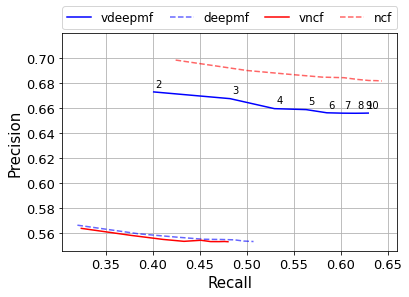

In [ ]:
for m in methods:
    precision = np.zeros(len(num_recommendations))
    recall = np.zeros(len(num_recommendations))
    
    for i, n in enumerate(num_recommendations):
        ids = preds[['user', 'item']].to_numpy()
        y_true = preds['y_test'].to_numpy()
        y_pred = preds[m].to_numpy()
        precision[i], recall[i] = calculate_precision_recall(ids, y_true, y_pred, n, args.like_threshold) 

    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'
        
    plt.plot(recall, precision, c=c, ls=ls, alpha=alpha, label=m)

    if m == 'vdeepmf':
        for i,(r,p) in enumerate(zip(recall, precision)):
            plt.annotate(num_recommendations[i], (r,p), textcoords="offset points", xytext=(5,5), ha='center')
    
plt.xlabel('Recall', fontsize=15); 
plt.ylabel('Precision', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods))

plt.grid(True)

ylim_min, ylim_max = plt.ylim()
plt.ylim((ylim_min, ylim_max * 1.02))

plt.show()

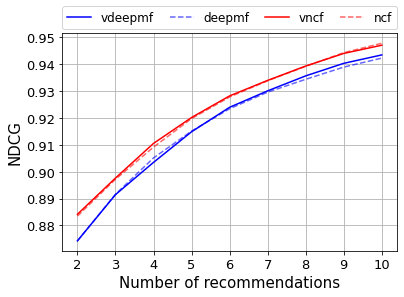

In [ ]:
for m in methods:
    ndcg = np.zeros(len(num_recommendations))
    
    for i, n in enumerate(num_recommendations):
        ids = preds[['user', 'item']].to_numpy()
        y_true = preds['y_test'].to_numpy()
        y_pred = preds[m].to_numpy()
        ndcg[i] = calculate_ndcg(ids, y_true, y_pred, n) 
        
    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'
 
    plt.plot(num_recommendations, ndcg, c=c, ls=ls, alpha=alpha, label=m)

plt.xlabel('Number of recommendations', fontsize=15); 
plt.ylabel('NDCG', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods))

plt.grid(True)

plt.show()

---

## **Closure**

For more details, you can refer to https://github.com/RecoHut-Stanzas/S394070.

<a href="https://github.com/RecoHut-Stanzas/S394070/blob/main/reports/S394070_Report.ipynb" alt="S394070_Report"> <img src="https://img.shields.io/static/v1?label=report&message=active&color=green" /></a> <a href="https://github.com/RecoHut-Stanzas/S394070" alt="S394070"> <img src="https://img.shields.io/static/v1?label=code&message=github&color=blue" /></a>

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-19 04:25:12

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas    : 1.1.5
numpy     : 1.19.5
matplotlib: 3.2.2
tensorflow: 2.7.0
IPython   : 5.5.0



---

**END**